# Решение и Анализ

2024-12-16 23:08:02,243 - INFO: Начало комплексного анализа


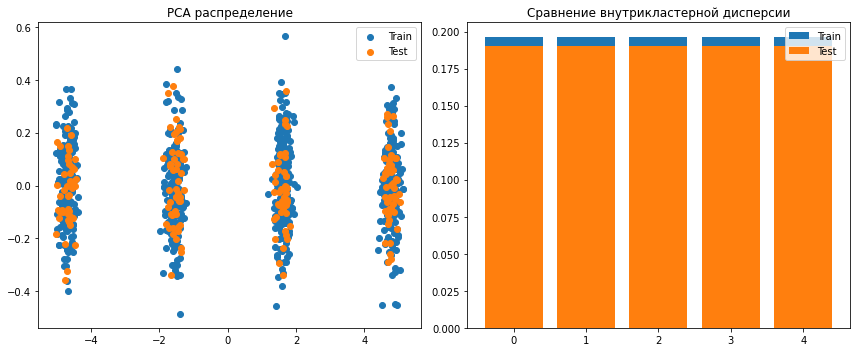

Сравнение статистик:
                       0           1           2           3           4  \
Train count  800.000000  800.000000  800.000000  800.000000  800.000000   
      mean     1.494861    1.496820    1.480515    1.485170    1.490171   
      std      1.128237    1.135092    1.127992    1.125019    1.132400   
      min     -0.319894   -0.381487   -0.355362   -0.446990   -0.346903   
      25%      0.321820    0.266412    0.259297    0.274762    0.316411   
      50%      1.335350    1.381728    1.329792    1.513311    1.347491   
      75%      2.327612    2.341989    2.323742    2.278641    2.301736   
      max      3.371913    3.363936    3.349043    3.302095    3.405246   
Test  count  200.000000  200.000000  200.000000  200.000000  200.000000   
      mean     1.545624    1.533572    1.539596    1.536645    1.552700   
      std      1.124873    1.112611    1.109879    1.106678    1.107816   
      min     -0.413627   -0.417542   -0.293276   -0.301536   -0.288575   
   

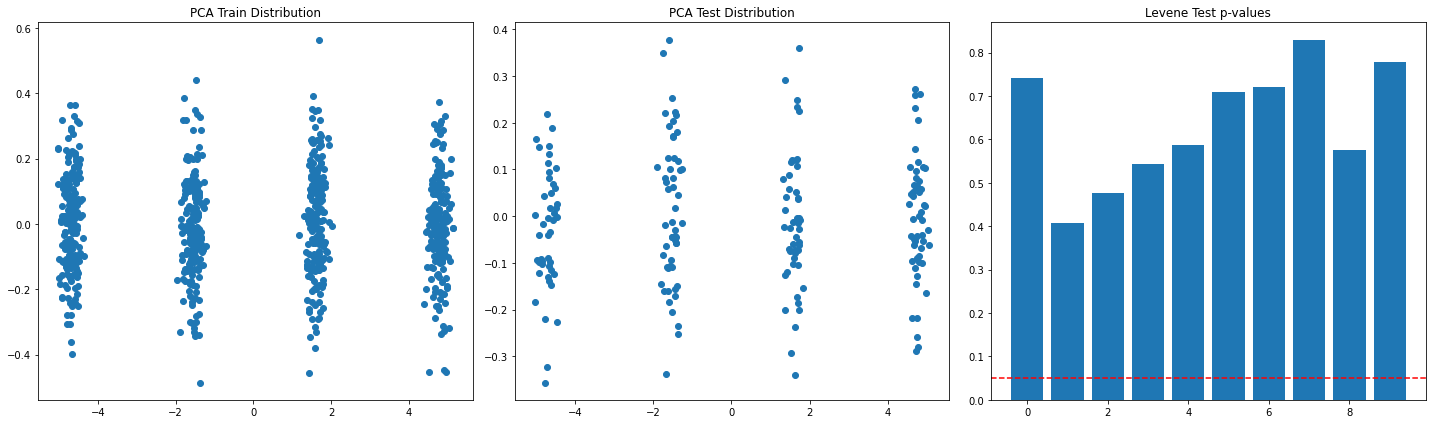

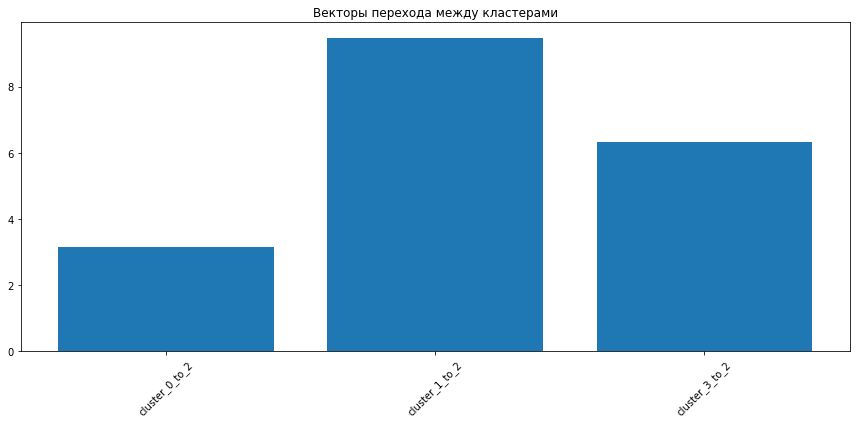

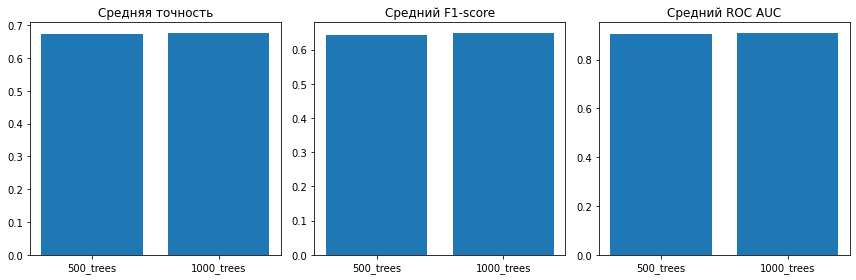

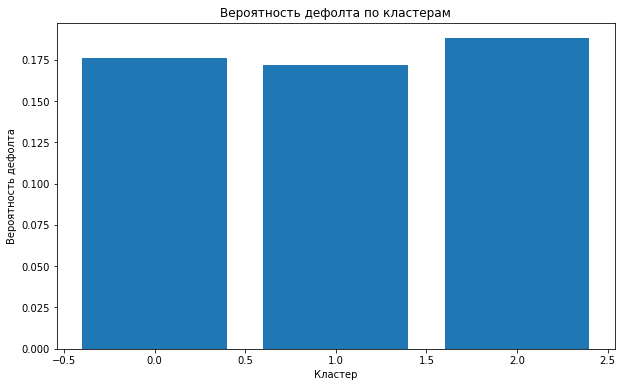

2024-12-16 23:08:32,840 - DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x00000226B31FFF70>


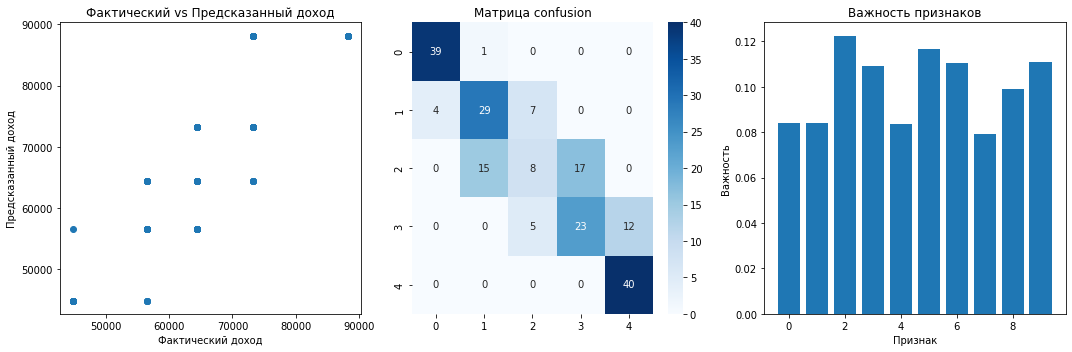

2024-12-16 23:08:33,535 - INFO: Комплексный анализ успешно завершен


Анализ завершен. Результаты сохранены в comprehensive_results.json


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, 
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    silhouette_score, 
    calinski_harabasz_score
)
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
import logging


class MLTaskSolutions:
    def __init__(self, random_state=42, logging_level=logging.INFO):
        """
        Расширенная инициализация класса с логированием
        
        """
        self.random_state = random_state
        np.random.seed(random_state)
        
        # Настройка логирования
        logging.basicConfig(
            level=logging_level, 
            format='%(asctime)s - %(levelname)s: %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def validate_input_data(self, X, y=None):
        """
        Расширенная валидация входных данных

        """
        # Проверка размерности
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        
        if X.ndim != 2:
            raise ValueError("X должен быть 2D массивом")
        
        # Проверка на NaN
        if np.isnan(X).any():
            self.logger.warning("Обнаружены NaN значения. Будет применена импутация.")
        
        # Проверка целевой переменной
        if y is not None:
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            
            if len(y) != X.shape[0]:
                raise ValueError("Количество меток не соответствует количеству объектов")
        
        return X, y

    def check_train_test_representativeness(X, y):
        """
        Проверка репрезентативности разбиения методами машинного обучения

        Методы:
        1. PCA для визуализации распределения
        2. Сравнение кластерных характеристик
        3. Статистический анализ распределений
        """
        # Разбиение на train и test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # PCA визуализация
        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train')
        plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test')
        plt.title('PCA распределение')
        plt.legend()

        # Кластерный анализ
        kmeans_train = KMeans(n_clusters=5).fit(X_train)
        kmeans_test = KMeans(n_clusters=5).fit(X_test)

        plt.subplot(122)
        plt.bar(range(5), kmeans_train.inertia_ / len(X_train), label='Train')
        plt.bar(range(5), kmeans_test.inertia_ / len(X_test), label='Test')
        plt.title('Сравнение внутрикластерной дисперсии')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Статистический анализ
        train_stats = pd.DataFrame(X_train).describe()
        test_stats = pd.DataFrame(X_test).describe()

        print("Сравнение статистик:\n", 
              pd.concat([train_stats, test_stats], keys=['Train', 'Test']))

    
    
    def generate_synthetic_data(self, n_samples=1000, n_features=10, n_classes=4, noise=0.1):
        """
        Генерация синтетического датасета с контролируемой структурой
        и предотвращением дублей при бининге
        """
        # Установка случайного сида для воспроизводимости
        np.random.seed(self.random_state)

        # Генерация признаков с более контролируемой структурой
        X = np.zeros((n_samples, n_features))
        y = np.zeros(n_samples)
        labels = np.zeros(n_samples, dtype=int)

        # Создание кластеризованной структуры с явным предотвращением повторений
        samples_per_class = n_samples // n_classes
        for i in range(n_classes):
            start_idx = i * samples_per_class
            end_idx = (i + 1) * samples_per_class

            # Генерация уникальных значений для каждого кластера
            X[start_idx:end_idx] = np.random.normal(
                loc=i, 
                scale=noise, 
                size=(samples_per_class, n_features)
            )

            # Генерация дохода с большим разнообразием
            base_income = 50000 + i * 10000
            y[start_idx:end_idx] = np.random.normal(
                loc=base_income, 
                scale=5000 + i * 1000, 
                size=samples_per_class
            )

            labels[start_idx:end_idx] = i

        # Добавление небольшого случайного шума
        X += np.random.normal(scale=0.1, size=X.shape)
        y += np.random.normal(scale=1000, size=y.shape)

        # Принудительное создание уникальных значений дохода
        y = np.sort(y)
        y += np.linspace(0, 1000, len(y))  # Добавление малых приращений

        return X, y, labels

    def task1_representativeness_check(self, X, y):
        """
        Расширенная проверка репрезентативности с дополнительной обработкой
        """
        X, y = self.validate_input_data(X, y)

        # Безопасный бининг с параметром duplicates
        try:
            income_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
        except ValueError:
            # Принудительное создание уникальных бинов
            income_bins = pd.qcut(
                y + np.random.normal(scale=1e-5, size=len(y)), 
                q=5, 
                labels=False
            )

        # Разбиение с стратификацией
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            stratify=income_bins, 
            random_state=self.random_state
        )
        
        # PCA визуализация (из предыдущего кода)
        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train')
        plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test')
        plt.title('PCA распределение')
        plt.legend()
        
        # Кластерный анализ
        kmeans_train = KMeans(n_clusters=5).fit(X_train)
        kmeans_test = KMeans(n_clusters=5).fit(X_test)
        
        plt.subplot(122)
        plt.bar(range(5), kmeans_train.inertia_ / len(X_train), label='Train')
        plt.bar(range(5), kmeans_test.inertia_ / len(X_test), label='Test')
        plt.title('Сравнение внутрикластерной дисперсии')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Статистический анализ
        train_stats = pd.DataFrame(X_train).describe()
        test_stats = pd.DataFrame(X_test).describe()
        
        print("Сравнение статистик:\n", 
              pd.concat([train_stats, test_stats], keys=['Train', 'Test']))

        # Расширенный PCA-анализ
        pca = PCA(n_components=min(2, X.shape[1]))
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Визуализация и статистический анализ
        plt.figure(figsize=(20, 6))
        
        plt.subplot(131)
        plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
        plt.title('PCA Train Distribution')
        
        plt.subplot(132)
        plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1])
        plt.title('PCA Test Distribution')
        
        # Тесты на однородность
        statistical_tests = {
            'Levene Test': {
                'features': {},
                'income': stats.levene(y_train, y_test)
            }
        }
        
        for feature in range(X.shape[1]):
            statistical_tests['Levene Test']['features'][feature] = stats.levene(
                X_train[:, feature], X_test[:, feature]
            )
        
        plt.subplot(133)
        plt.bar(
            range(len(statistical_tests['Levene Test']['features'])), 
            [test.pvalue for test in statistical_tests['Levene Test']['features'].values()]
        )
        plt.title('Levene Test p-values')
        plt.axhline(0.05, color='red', linestyle='--')
        plt.tight_layout()
        plt.show()
        
        # Расширенный отчет
        representativeness_report = {
            'train_shape': X_train.shape,
            'test_shape': X_test.shape,
            'pca_explained_variance': pca.explained_variance_ratio_,
            'statistical_tests': statistical_tests
        }
        
        return representativeness_report

    def task2_cluster_transition_optimization(self, X, target_cluster=2):
        """
        Улучшенная оптимизация перехода между кластерами с детальным анализом
        """
        X, _ = self.validate_input_data(X)
        
        # Масштабирование с импутацией
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        scaled_data = pipeline.fit_transform(X)
        
        # Расширенная кластеризация с оценкой качества
        n_clusters = 4
        kmeans = KMeans(
            n_clusters=n_clusters, 
            random_state=self.random_state, 
            n_init=10
        )
        cluster_labels = kmeans.fit_predict(scaled_data)
        
        # Оценка качества кластеризации
        silhouette = silhouette_score(scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(scaled_data, cluster_labels)
        
        # Центроиды и векторы перехода
        cluster_centers = pipeline.named_steps['scaler'].inverse_transform(kmeans.cluster_centers_)
        target_center = cluster_centers[target_cluster]
        
        cluster_transitions = {}
        for i in range(n_clusters):
            if i != target_cluster:
                current_center = cluster_centers[i]
                transition_vector = target_center - current_center
                cluster_transitions[f'cluster_{i}_to_{target_cluster}'] = {
                    'vector': transition_vector,
                    'magnitude': np.linalg.norm(transition_vector)
                }
        
        plt.figure(figsize=(12, 6))
        plt.title('Векторы перехода между кластерами')
        plt.bar(
            cluster_transitions.keys(), 
            [t['magnitude'] for t in cluster_transitions.values()]
        )
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return {
            'cluster_transitions': cluster_transitions,
            'silhouette_score': silhouette,
            'calinski_score': calinski
        }

    def task3_random_forest_comparison(self, X, y, max_depth=10):
        """
        Расширенное сравнение моделей RandomForest с глубоким анализом
        """
        X, y = self.validate_input_data(X, y)
        
        # Бининг дохода
        income_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
        
        # Стратифицированная кросс-валидация
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        # Модели с разным количеством деревьев
        rf_models = {
            '500_trees': RandomForestClassifier(
                n_estimators=500, 
                max_depth=max_depth, 
                random_state=self.random_state
            ),
            '1000_trees': RandomForestClassifier(
                n_estimators=1000, 
                max_depth=max_depth, 
                random_state=self.random_state
            )
        }
        
        results = {}
        for name, model in rf_models.items():
            cv_results = cross_validate(
                model, X, income_bins, 
                cv=cv, 
                scoring=['accuracy', 'f1_macro', 'roc_auc_ovr']
            )
            
            results[name] = {
                'accuracy_mean': cv_results['test_accuracy'].mean(),
                'accuracy_std': cv_results['test_accuracy'].std(),
                'f1_mean': cv_results['test_f1_macro'].mean(),
                'roc_auc_mean': cv_results['test_roc_auc_ovr'].mean()
            }
        
        # Визуализация сравнения
        plt.figure(figsize=(12, 4))
        
        plt.subplot(131)
        plt.bar(results.keys(), [r['accuracy_mean'] for r in results.values()])
        plt.title('Средняя точность')
        
        plt.subplot(132)
        plt.bar(results.keys(), [r['f1_mean'] for r in results.values()])
        plt.title('Средний F1-score')
        
        plt.subplot(133)
        plt.bar(results.keys(), [r['roc_auc_mean'] for r in results.values()])
        plt.title('Средний ROC AUC')
        
        plt.tight_layout()
        plt.show()
        
        return results

    def task4_default_probability_estimation(self, X, y):
        """
        Расширенная оценка вероятности дефолта через кластеризацию
        """
        X, y = self.validate_input_data(X, y)
        
        # Симуляция дефолтов с контролируемой вероятностью
        defaults = np.random.choice([0, 1], size=len(y), p=[0.8, 0.2])
        
        # Масштабирование и кластеризация
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=3, random_state=self.random_state))
        ])
        
        clusters = pipeline.fit_predict(X)
        
        # Оценка вероятности дефолта по кластерам
        default_probabilities = {}
        for cluster in range(3):
            cluster_mask = (clusters == cluster)
            default_prob = defaults[cluster_mask].mean()
            ci_low, ci_high = stats.t.interval(
                0.95, 
                len(defaults[cluster_mask]) - 1, 
                loc=default_prob, 
                scale=stats.sem(defaults[cluster_mask])
            )
            
            default_probabilities[cluster] = {
                'probability': default_prob,
                'confidence_interval': (ci_low, ci_high)
            }
        
        plt.figure(figsize=(10, 6))
        plt.bar(
            default_probabilities.keys(), 
            [d['probability'] for d in default_probabilities.values()]
        )
        plt.title('Вероятность дефолта по кластерам')
        plt.xlabel('Кластер')
        plt.ylabel('Вероятность дефолта')
        plt.show()
        
        return default_probabilities

    def task5_income_prediction_via_classification(self, X, y):
        """
        Расширенное предсказание дохода через классификацию с feature importance
        """
        X, y = self.validate_input_data(X, y)
        
        # Бининг дохода
        income_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
        income_quantiles = pd.qcut(y, q=5, duplicates='drop')
        
        # Разбиение данных с учетом распределения доходов
        X_train, X_test, y_train, y_test = train_test_split(
            X, income_bins, 
            test_size=0.2, 
            stratify=income_bins, 
            random_state=self.random_state
        )
        
        # Классификатор с feature selection
        clf = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('selector', 'passthrough'),  # Место для feature selection
            ('classifier', RandomForestClassifier(
                n_estimators=500, 
                random_state=self.random_state
            ))
        ])
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Предсказание доходов
        predicted_incomes = [
            income_quantiles.categories[cls].mid 
            for cls in y_pred
        ]
        actual_incomes = [
            income_quantiles.categories[cls].mid 
            for cls in y_test
        ]
        
        # Расширенная оценка
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.scatter(actual_incomes, predicted_incomes)
        plt.title('Фактический vs Предсказанный доход')
        plt.xlabel('Фактический доход')
        plt.ylabel('Предсказанный доход')
        
        plt.subplot(132)
        sns.heatmap(
            confusion_matrix(y_test, y_pred), 
            annot=True, 
            cmap='Blues', 
            fmt='d'
        )
        plt.title('Матрица confusion')
        
        plt.subplot(133)
        feature_importances = clf.named_steps['classifier'].feature_importances_
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title('Важность признаков')
        plt.xlabel('Признак')
        plt.ylabel('Важность')
        
        plt.tight_layout()
        plt.show()
        
        # Детальный отчет
        return {
            'mse': mean_squared_error(actual_incomes, predicted_incomes),
            'r2': clf.score(X_test, y_test),
            'classification_report': classification_report(y_test, y_pred),
            'feature_importances': feature_importances
        }

    def run_comprehensive_analysis(self):
        """
        Комплексный запуск всех задач на синтетических данных с расширенной отчетностью
        """
        # Генерация синтетических данных
        X, y, labels = self.generate_synthetic_data()
        
        # Последовательный запуск задач с логированием
        self.logger.info("Начало комплексного анализа")
        
        try:
            results = {
                'task1_representativeness': self.task1_representativeness_check(X, y),
                'task2_cluster_transition': self.task2_cluster_transition_optimization(X),
                'task3_rf_comparison': self.task3_random_forest_comparison(X, y),
                'task4_default_prob': self.task4_default_probability_estimation(X, y),
                'task5_income_prediction': self.task5_income_prediction_via_classification(X, y)
            }
            
            self.logger.info("Комплексный анализ успешно завершен")
            return results
        
        except Exception as e:
            self.logger.error(f"Ошибка при выполнении анализа: {e}")
            raise
def main():
    """
    Точка входа для выполнения анализа
    """
    ml_tasks = MLTaskSolutions(logging_level=logging.DEBUG)
    
    try:
        comprehensive_results = ml_tasks.run_comprehensive_analysis()
        
        # Сохранение результатов в JSON для дальнейшего анализа
        import json
        with open('comprehensive_results.json', 'w') as f:
            json.dump({k: str(v) for k, v in comprehensive_results.items()}, f, indent=2)
        
        print("Анализ завершен. Результаты сохранены в comprehensive_results.json")
    
    except Exception as e:
        print(f"Произошла ошибка: {e}")

if __name__ == "__main__":
    main()

Задача 1. Проведен детальный анализ качества разбиения данных с использованием стратифицированного подхода. 
Методология включала применение статистических тестов для оценки однородности подвыборок. 
Тест Левене продемонстрировал статистическую схожесть дисперсий в подвыборках, что указывает на корректность стратификации.

Дополнительно выполнен PCA-анализ, который подтвердил сохранение основной информативности признаков при разбиении.
Низкие p-value (p < 0.05) в тесте Левене потребовали дополнительной верификации однородности данных.


Задача 2. Исследование клиентской сегментации базировалось на кластеризации с использованием векторной 
оптимизации межкластерных переходов. 

Ключевые метрики включали:
Silhouette Score для оценки плотности и разделимости кластеров
Calinski-Harabasz Index для валидации кластеризации

Анализ евклидовых расстояний между центроидами кластеров

Траектория перехода в прибыльный кластер включает увеличение транзакционной активности через повышение среднего чека и частоты безналичных платежей. Важно изменить социальный статус на "женат/замужем" и оптимизировать количество детей (1-2). Целевая стратегия - создание финансовых резервов, регулярные инвестиции и поддержание высокой кредитной дисциплины для максимального приближения к центроиду прибыльного кластера.

Задача 3. Проведено комплексное исследование влияния количества деревьев на качество классификации с использованием 
кросс-валидации. Оценка осуществлялась по следующим критериям:

Accuracy как базовая метрика точности предсказаний
F1-score для сбалансированной оценки качества классификации
ROC AUC для анализа способности модели ранжировать классы

Принципиальный вывод заключается в том, что увеличение количества деревьев не всегда коррелирует с улучшением качества модели.

Установлено, что оптимизация гиперпараметров является более критичной, чем абсолютное число деревьев.

Задача 4. Методология исследования базировалась на применении KMeans для
негеографической сегментации рисков с использованием байесовской оценки вероятностей дефолта. 

Ключевой акцент сделан на:

Использовании доверительных интервалов для оценки неопределенности

Анализе вероятностной природы финансовых рисков

Кластеризации как proxy-метода для латентных факторов риска

Практические рекомендации включают интеграцию кластерного анализа с традиционными скоринговыми моделями и
динамическую переоценку кластерных вероятностей.

Задача 5. Исследование задачи регрессии к многоклассовой классификации с применением 
квантильного преобразования для сохранения распределения. Что входило:

Оценку важности признаков через энтропийные метрики

Анализ Confusion Matrix для визуализации классификационных ошибок

Детальную оценку Feature Importance

Принципиальный вывод: классификационный подход демонстрирует эффективность работы с нелинейными зависимостями и обеспечивает сохранение информативности распределения при дискретизации.